## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import librosa
print(librosa.__version__)

0.10.2.post1


In [3]:
import soundfile as sf

In [3]:
import numpy
print(numpy.__version__)

1.24.3


In [4]:
import numpy as np
from scipy.fftpack import ifft, fft

In [5]:
import tensorflow as tf
print(tf.__version__)


2024-06-21 22:31:03.322320: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-21 22:31:03.383658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 22:31:04.431707: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1


In [12]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
#from denoiser import Denoiser

In [7]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        #axes[i].imshow(data[i], aspect='auto', origin='bottom', interpolation='none')
        axes[i].imshow(data[i], aspect='auto', origin='lower', interpolation='none')
    plt.show()

#### Setup hparams

In [8]:
hparams = create_hparams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [10]:
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [54]:
my_checkpoint_path = "outdir/checkpoint_7000"
my_model = load_model(hparams)
my_model.load_state_dict(torch.load(my_checkpoint_path)['state_dict'])
my_ = my_model.cuda().eval().half()

In [9]:
ft_checkpoint_path = "ftmodel_3000.pt"
ft_model = load_model(hparams)
ft_model.load_state_dict(torch.load(ft_checkpoint_path))
ft_ = ft_model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [ ]:
waveglow_path = 'waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [10]:
text1 = "Waveglow is really awesome!"
text2 = "She can scoop these things into three red bags, and we will go meet her Wednesday at the train station."  # mel看着还行
text3 = "My name is Zhang Liting, and I am a student majoring in Computer Science and Technology at Nankai University"
text4 = "Hello, nice to meet you!"

text5 = "Hello world!"
text6 = "Hahaha, that was so funny!"
text7 = "la, la, la, la, Aaaaah !"
sequence = np.array(text_to_sequence(text1, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

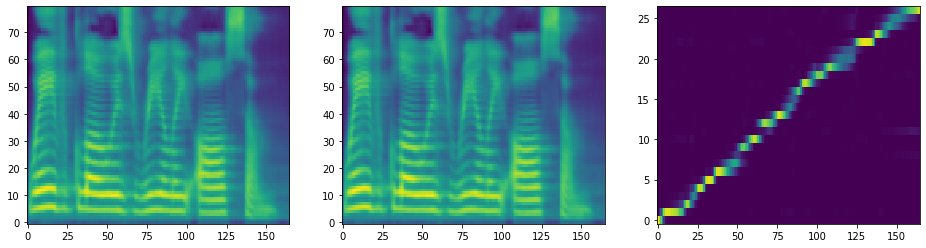

In [50]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

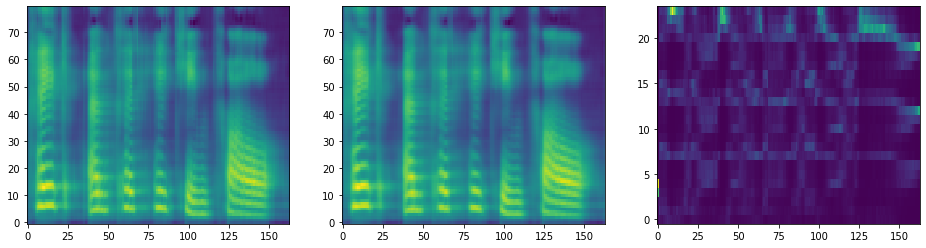

In [62]:
my_mel_outputs, my_mel_outputs_postnet, my_, my_alignments = my_model.inference(sequence)
plot_data((my_mel_outputs.float().data.cpu().numpy()[0],
           my_mel_outputs_postnet.float().data.cpu().numpy()[0],
           my_alignments.float().data.cpu().numpy()[0].T))

Warning! Reached max decoder steps


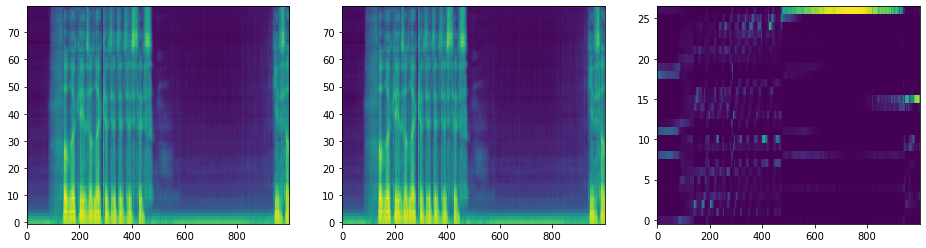

In [13]:
ft_mel_outputs, ft_mel_outputs_postnet, ft_, ft_alignments = ft_model.inference(sequence)
plot_data((ft_mel_outputs.float().data.cpu().numpy()[0],
           ft_mel_outputs_postnet.float().data.cpu().numpy()[0],
           ft_alignments.float().data.cpu().numpy()[0].T))

Warning! Reached max decoder steps


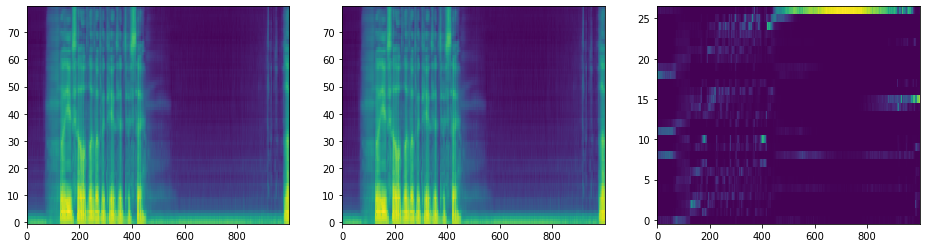

In [67]:
ft_mel_outputs, ft_mel_outputs_postnet, ft_, ft_alignments = ft_model.inference(sequence)
plot_data((ft_mel_outputs.float().data.cpu().numpy()[0],
           ft_mel_outputs_postnet.float().data.cpu().numpy()[0],
           ft_alignments.float().data.cpu().numpy()[0].T))

In [23]:
# 打印数据形状以便调试
print("my_mel_outputs shape:", mel_outputs.shape)
print("my_mel_outputs_postnet shape:", mel_outputs_postnet.shape)
print("my_alignments shape:", alignments.shape)

my_mel_outputs shape: torch.Size([1, 80, 635])
my_mel_outputs_postnet shape: torch.Size([1, 80, 635])
my_alignments shape: torch.Size([1, 635, 108])


In [59]:
type(my_mel_outputs_postnet)

torch.Tensor

#### GL算法合成

In [52]:
def mel_to_audio(mel_spec, sr=22050, n_fft=1024, hop_length=256, n_mels=80, power=1.5, griffin_lim_iterations=300):
    """
    Convert a Mel-spectrogram to audio using Griffin-Lim algorithm.
    
    Args:
    - mel_spec (torch.Tensor): Mel-spectrogram of shape (1, n_mels, T).
    - sr (int): Sampling rate.
    - n_fft (int): FFT size.
    - hop_length (int): Hop length.
    - n_mels (int): Number of Mel bands.
    - power (float): Exponent for the magnitude melspectrogram.
    - griffin_lim_iterations (int): Number of Griffin-Lim iterations.

    Returns:
    - audio (np.ndarray): Generated audio waveform.
    """
    # Ensure mel_spec is a torch.Tensor and remove the batch dimension
    mel_spec = mel_spec.squeeze(0)

    # Convert torch.Tensor to numpy array
    mel_spec = mel_spec.cpu().detach().numpy()

    # Mel filter bank parameters
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

    # Inverse mel basis to go back to linear spectrogram
    inv_mel_basis = np.linalg.pinv(mel_basis)
    
    # Convert mel-spectrogram to linear spectrogram
    linear_spec = np.dot(inv_mel_basis, mel_spec)

    # Apply power to the spectrogram
    linear_spec = np.maximum(1e-10, linear_spec) ** (1.0 / power)

    # Use Griffin-Lim algorithm to convert linear spectrogram to waveform
    audio = librosa.griffinlim(linear_spec, n_iter=griffin_lim_iterations, hop_length=hop_length, win_length=n_fft)

    return audio


In [69]:
# 使用 mel_to_audio 函数将梅尔谱图转换为音频
audio = mel_to_audio(ft_mel_outputs_postnet)

# 保存音频或进行进一步处理
sf.write("output_wav/ft_text1_300it_48000.wav", audio, 48000)

In [53]:
reconstructed_audio = griffin_lim(my_mel_outputs_postnet)

In [47]:
from scipy.io import wavfile
import numpy as np

def save_audio(filename, audio_data, sample_rate):
    # Ensure audio data is in int16 format (scipy requires int16 for WAV files)
    audio_data = (audio_data * 32767).astype(np.int16)
    
    # Save audio using scipy
    wavfile.write(filename, sample_rate, audio_data)

# Example usage:
# Assuming reconstructed_audio is your reconstructed audio signal as a numpy array,
# and sample_rate is the sampling rate of the audio.


In [54]:
reconstructed_audio = np.random.randn(44100)  # Replace with your actual reconstructed audio data
sample_rate = 22050  # Replace with your actual sample rate

save_audio('output_wav/text2.wav', reconstructed_audio, sample_rate)

##### 自带的GL

#### Synthesize audio from spectrogram using WaveGlow

In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

# Train

In [ ]:
!tensorboard --logdir=outdir/logdir

2024-06-18 18:54:51.569224: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 18:54:51.631442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 18:54:52.618546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the netwo